In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# flags
epochs = 20
input_dim = 28*28
batch_size = 128
hidden_dim = 256
latent_dim = 2 # latent 2d plane

In [2]:
# end-to-end vae model
# encoder layer
encoder_input = Input(shape=(input_dim,))
hidden1 = Dense(hidden_dim,activation='relu')(encoder_input)
sampler_mean = Dense(latent_dim)(hidden1)
sampler_log_stddev = Dense(latent_dim)(hidden1)

# sampler
def sample(args):
    mean,log_stddev = args
    sigma = K.sqrt(K.exp(log_stddev))
    epsilon = K.random_normal(shape=(latent_dim,))
    # sampling from Z~N(μ, σ^2) is the same as sampling from μ + σ X where X~N(0,1)                            
    return mean + sigma * epsilon
sampler = Lambda(sample, output_shape = (latent_dim,))([sampler_mean, sampler_log_stddev])

# decoder
hidden2 = Dense(hidden_dim,activation='relu')
hidden2_decoded = hidden2(sampler)
hidden3 = Dense(input_dim,activation='sigmoid')
decoder_ouput = hidden3(hidden2_decoded)

# vae
vae = Model(encoder_input, decoder_ouput) 
for layer in vae.layers:
    print(layer.input_shape, layer.output_shape)

Instructions for updating:
Colocations handled automatically by placer.
(None, 784) (None, 784)
(None, 784) (None, 256)
(None, 256) (None, 2)
(None, 256) (None, 2)
[(None, 2), (None, 2)] (None, 2)
(None, 2) (None, 256)
(None, 256) (None, 784)
Tensor("loss/dense_4_loss/Sum:0", shape=(?,), dtype=float32)
Tensor("loss/dense_4_loss/mul:0", shape=(?,), dtype=float32)


In [ ]:
def loss(encoder_input, decoder_ouput):
    # expected negative log-likelihood
    reconstruction_error = K.sum(K.binary_crossentropy(encoder_input,decoder_ouput),axis=-1)
    print(reconstruction_error)
    # Kullback–Leibler divergence, relative entropy
    kl_divergence = -0.5 * K.sum(1 + sampler_log_stddev - K.square(sampler_mean) - K.exp(sampler_log_stddev), axis=-1)
    print(kl_divergence)

    return reconstruction_error+kl_divergence

vae.compile('rmsprop', loss = loss)


# encoder
# input to latent encoder, reuse vae
encoder = Model(encoder_input,sampler_mean) 

# decoder/generator
# latent to reconstructed decoder, use new latent input, reuse hidden layer
generator_input = Input(shape=(latent_dim,))
generator_decoded = hidden2(generator_input)
generator_output = hidden3(generator_decoded)
generator = Model(generator_input, generator_output)

In [3]:
# prepare dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# reshape images and normalize
x_train = x_train.reshape(x_train.shape[0],input_dim).astype('float32') / 255.
x_test = x_test.reshape(x_test.shape[0],input_dim).astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [4]:
# train
vae.fit(
    x_train, 
    x_train,
    shuffle=True,
    epochs = epochs,
    batch_size = batch_size,
    validation_data=(x_test, x_test),
    verbose=2)

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 4s - loss: 199.1950 - val_loss: 176.2039
Epoch 2/20
 - 3s - loss: 174.3764 - val_loss: 171.9091
Epoch 3/20
 - 3s - loss: 170.2637 - val_loss: 170.2112
Epoch 4/20
 - 3s - loss: 168.0759 - val_loss: 168.0105
Epoch 5/20
 - 3s - loss: 166.4951 - val_loss: 165.8084
Epoch 6/20
 - 3s - loss: 165.2165 - val_loss: 165.0332
Epoch 7/20
 - 3s - loss: 164.0856 - val_loss: 163.1536
Epoch 8/20
 - 3s - loss: 163.1961 - val_loss: 162.6530
Epoch 9/20
 - 4s - loss: 162.1808 - val_loss: 162.2598
Epoch 10/20
 - 4s - loss: 161.2368 - val_loss: 160.8806
Epoch 11/20
 - 3s - loss: 160.4559 - val_loss: 160.2512
Epoch 12/20
 - 4s - loss: 159.7667 - val_loss: 159.9820
Epoch 13/20
 - 4s - loss: 159.1070 - val_loss: 159.1110
Epoch 14/20
 - 4s - loss: 158.5175 - val_loss: 159.6643
Epoch 15/20
 - 3s - loss: 158.0152 - val_loss: 158.8713
Epoch 16/20
 - 4s - loss: 157.6979 - val_loss: 157.7705
Epoch 17/20
 - 

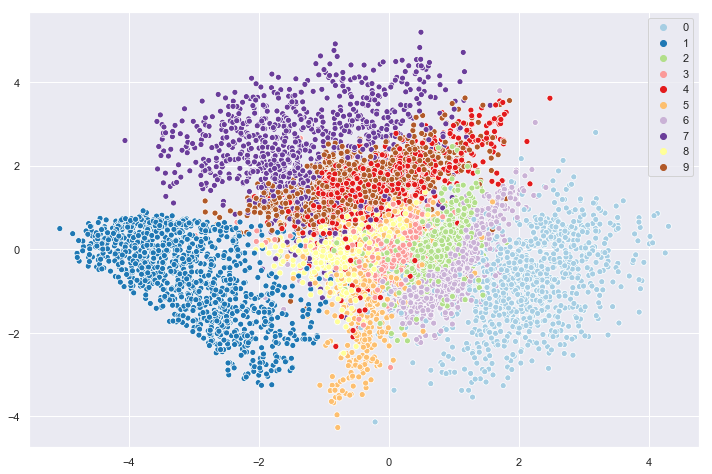

In [5]:
# plot x_test in latent plane
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 8)})

x_predict = encoder.predict(x_test, batch_size=batch_size)

sns.scatterplot(x=x_predict[:,0], 
                y=x_predict[:,1], 
                hue=y_test, 
                legend="full", 
                palette="Paired")

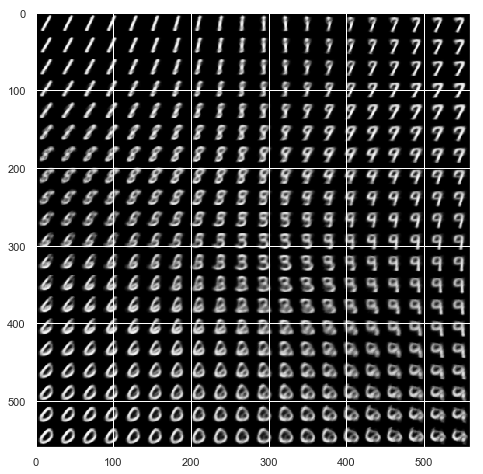

In [6]:
# plot latent plane
n = 20
img_size = 28

x_axis = np.linspace(-2,2,n)
y_axis = np.linspace(-2,2,n)
figure = np.zeros((img_size * n, img_size * n))

for i,xi in enumerate(x_axis):
    for j,yj in enumerate(y_axis):
        z = np.array([[xi,yj]]) * 1
        decoded = generator.predict(z)
        digit = decoded[0].reshape(img_size,img_size)
        figure[i * img_size: (i + 1) * img_size,
               j * img_size: (j + 1) * img_size] = digit
plt.imshow(figure,cmap='Greys_r')